# Advanced: Extending lambeq

## Creating readers

### Reader example: "Comb" reader

In this example we will create a reader that, given a sentence, it generates the following tensor network:

<center>
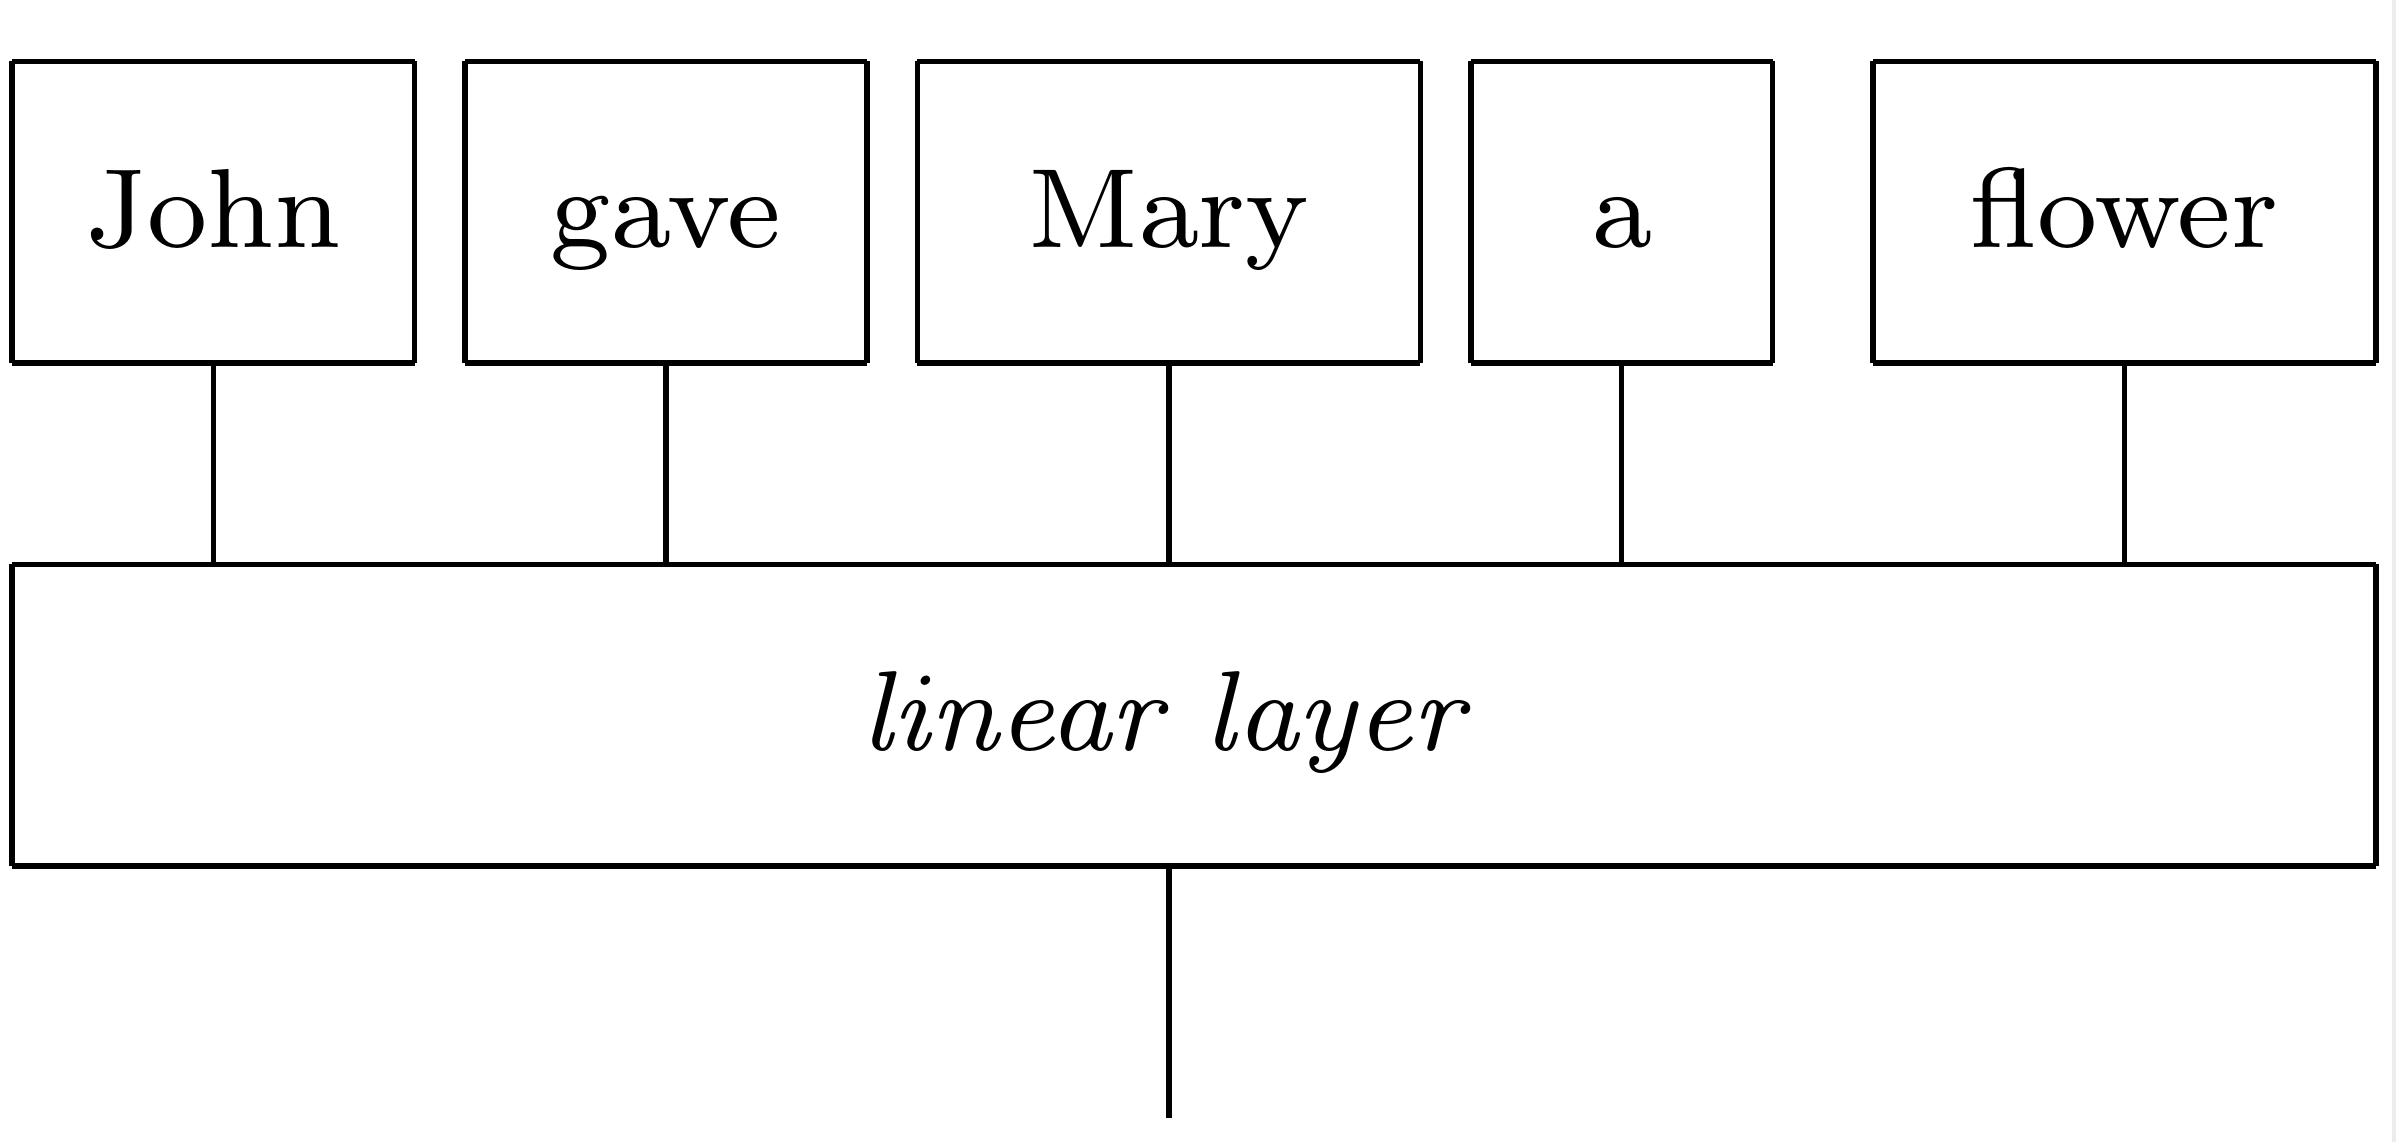
</center>

Note that the particular compositional model is not appropriate for classical experiments, since the tensor that implements the layer can become very large for long sentences. However, the model can be implemented without problems on a quantum computer.

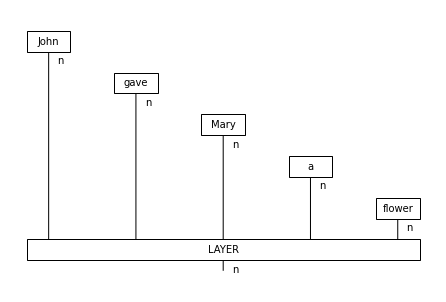

In [1]:
from lambeq import AtomicType, Reader
from discopy import Box, Id, Word

N = AtomicType.NOUN

class CombReader(Reader):
    def sentence2diagram(self, sentence):
        words = Id().tensor(*[Word(w, N) for w in sentence.split()])
        layer = Box('LAYER', words.cod, N)
        return words >> layer

diagram = CombReader().sentence2diagram('John gave Mary a flower')
diagram.draw()

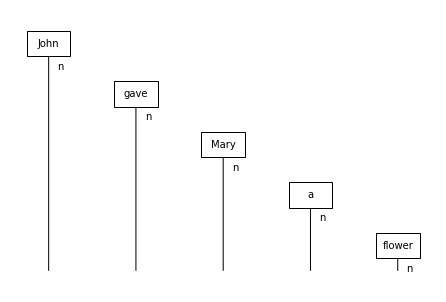

In [2]:
Id().tensor(*[Word(w, N) for w in ['John', 'gave', 'Mary', 'a', 'flower']]).draw()

## Creating rewrite rules

In [3]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')
d = parser.sentence2diagram('The food is fresh')

### SimpleRewriteRule example: Negation functor

In [4]:
from lambeq import AtomicType, SimpleRewriteRule
from discopy.rigid import Box, Id

N = AtomicType.NOUN
S = AtomicType.SENTENCE
adj = N @ N.l

NOT = Box('NOT', S, S)

negation_rewrite = SimpleRewriteRule(
    cod=N.r @ S @ S.l @ N,
    template=SimpleRewriteRule.placeholder(N.r @ S @ S.l @ N) >> Id(N.r) @ NOT @ Id(S.l @ N),
    words=['is', 'was', 'has', 'have'])

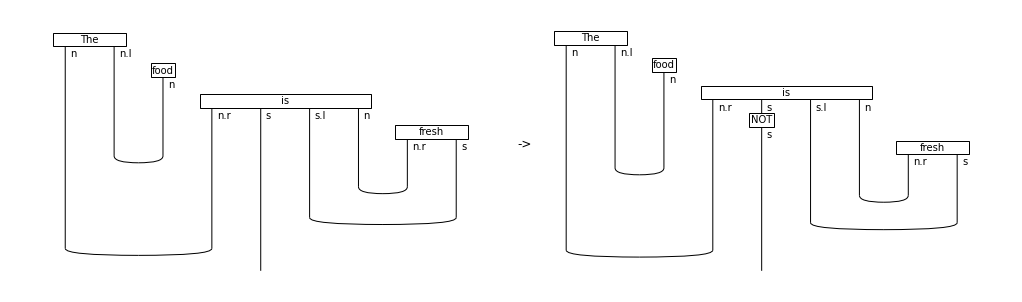

In [5]:
from lambeq import Rewriter
from discopy import drawing

not_d = Rewriter([negation_rewrite])(d)
drawing.equation(d, not_d, symbol='->', figsize=(14, 4))

### RewriteRule example: "Past" functor

In [6]:
from lambeq import RewriteRule

class PastRewriteRule(RewriteRule):
    mapping = {
        'is': 'was',
        'are': 'were',
        'has': 'had'
    }
    def matches(self, box):
        return box.name in self.mapping
    
    def rewrite(self, box):
        new_name = self.mapping[box.name]
        return type(box)(name=new_name, dom=box.dom, cod=box.cod)

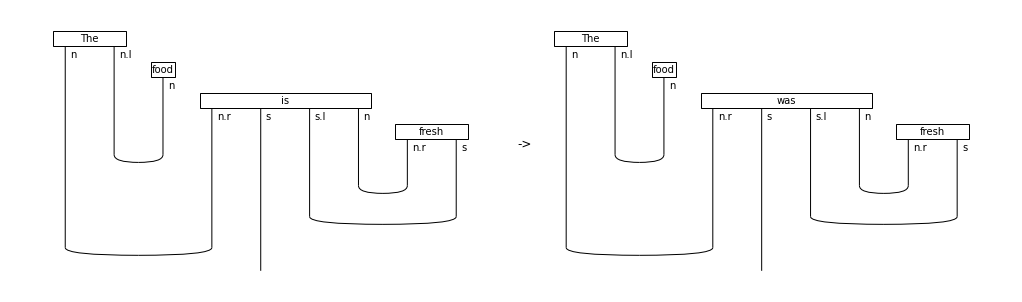

In [7]:
past_d = Rewriter([PastRewriteRule()])(d)
drawing.equation(d, past_d, symbol='->', figsize=(14, 4))

## Creating ansätze

In [8]:
d = parser.sentence2diagram('We will go')

### CircuitAnsatz example: "Real-valued" ansatz

In [9]:
from discopy.quantum.circuit import Functor, Id
from discopy.quantum.gates import Bra, CX, Ket, Ry
from lambeq import CircuitAnsatz
from lambeq.ansatz import Symbol

class RealAnsatz(CircuitAnsatz):
    def __init__(self, ob_map, n_layers):
        super().__init__(ob_map=ob_map, n_layers=n_layers)

        self.n_layers = n_layers
        self.functor = Functor(ob=self.ob_map, ar=self._ar)


    def _ar(self, box):
        # step 1: obtain label
        label = self._summarise_box(box)

        # step 2: map domain and codomain
        dom, cod = self._ob(box.dom), self._ob(box.cod)

        n_qubits = max(dom, cod)
        n_layers = self.n_layers
        
        # step 3: construct and return ansatz
        if n_qubits == 1:
            circuit = Ry(Symbol(f'{label}_0'))
        else:
            # this also deals with the n_qubits == 0 case correctly
            circuit = Id(n_qubits)
            for i in range(n_layers):
                offset = i * n_qubits
                syms = [Symbol(f'{label}_{offset + j}') for j in range(n_qubits)]

                # adds a ladder of CNOTs
                for j in range(n_qubits - 1):
                    circuit >>= Id(j) @ CX @ Id(n_qubits - j - 2)

                # adds a layer of Y rotations
                circuit >>= Id().tensor(*[Ry(sym) for sym in syms])

        if cod <= dom:
            circuit >>= Id(cod) @ Bra(*[0]*(dom - cod))
        else:
            circuit <<= Id(dom) @ Ket(*[0]*(cod - dom))
        return circuit

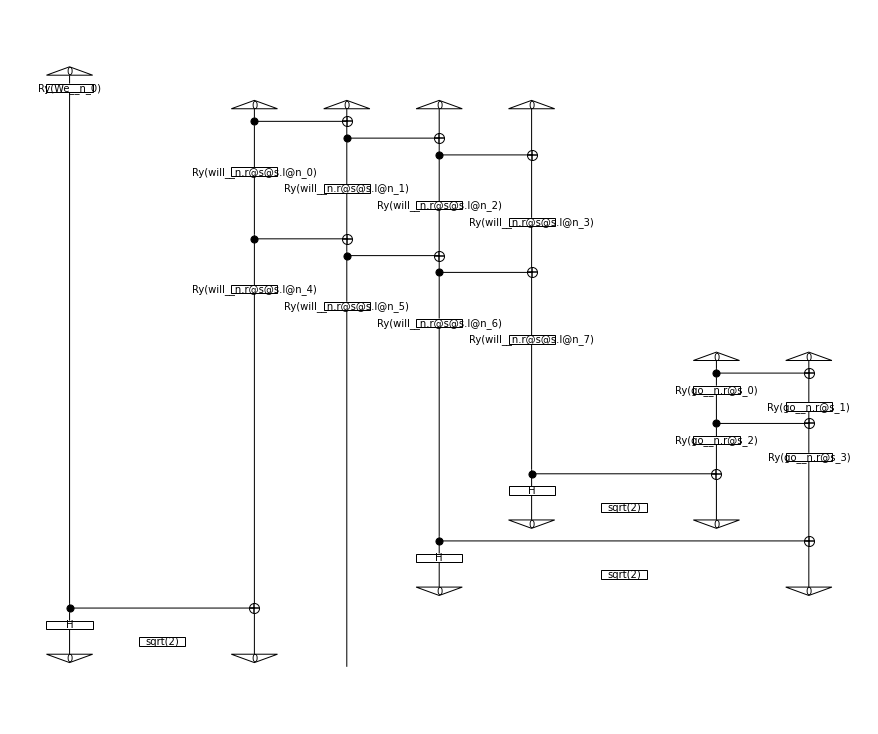

In [10]:
real_d = RealAnsatz({N: 1, S: 1}, n_layers=2)(d)
real_d.draw(figsize=(12, 10))

### TensorAnsatz example: "Positive" ansatz

In [11]:
from lambeq import TensorAnsatz
from discopy import rigid, tensor
from functools import reduce

class PositiveAnsatz(TensorAnsatz):
    def _ar(self, box):
        # step 1: obtain label
        label = self._summarise_box(box)

        # step 2: map domain and codomain
        dom, cod = self._ob(box.dom), self._ob(box.cod)

        # step 3: construct and return ansatz
        name = self._summarise_box(box)
        n_params = reduce(lambda x, y: x * y, dom @ cod, 1)
        syms = Symbol(name, size=n_params)
        return tensor.Box(box.name, dom, cod, syms ** 2)

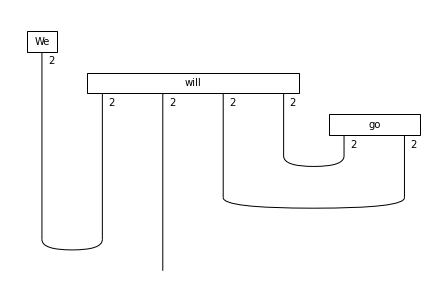

In [12]:
from discopy import Dim

ansatz = PositiveAnsatz({N: Dim(2), S: Dim(2)})
positive_d = ansatz(d)
positive_d.draw()

In [13]:
import numpy as np
from sympy import default_sort_key

syms = sorted(positive_d.free_symbols, key=default_sort_key)
sym_dict = {k: -np.ones(k.size) for k in syms}
subbed_diagram = positive_d.lambdify(*syms)(*sym_dict.values())

subbed_diagram.eval()

Tensor(dom=Dim(1), cod=Dim(2), array=[8., 8.])

## Contributions